In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

random_num = 777
torch.manual_seed(random_num)
np.random.seed(random_num)

In [2]:
df = pd.read_csv('/home/jsarrato/PersonalProjects/ML_Portfolio/Spam_Classifier/spam_ham_dataset.csv')

In [3]:
N_ham = len(df[df['label']=='ham'])
N_spam = len(df[df['label']=='spam'])

print(f"Total mails: {len(df)}")
print(f"Ham mails: {N_ham}")
print(f"Spam mails: {N_spam}")

Total mails: 5171
Ham mails: 3672
Spam mails: 1499


In [4]:
texts = df['text'].to_numpy()
labels = df['label_num'].to_numpy()

texts_train, texts_val, labels_train, labels_val = train_test_split(texts, labels, test_size = 0.2,random_state = random_num)
texts_val, texts_test, labels_val, labels_test = train_test_split(texts_val, labels_val, test_size = 0.5,random_state = random_num)

In [5]:
def build_vocab(texts, max_vocab_size='auto'):
    if max_vocab_size == 'auto':
        max_vocab_size = len(set(word for text in texts for word in text.split())) + 2 # +2 for <PAD> and <UNK>

    print(f"Building vocabulary with max size: {max_vocab_size}")

    counter = Counter()
    for text in texts:
        counter.update(text.split())

    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in counter.most_common(max_vocab_size - 2):
        vocab[word] = len(vocab)
    return vocab

In [6]:
vocab = build_vocab(texts)

Building vocabulary with max size: 50617


In [7]:
class SpamDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        text_indices = [self.vocab.get(word, self.vocab['<UNK>']) for word in text.split()[:self.max_len]] # Get token of word, or unknown. Cut excess after max_len
        text_indices = text_indices + [self.vocab['<PAD>']] * (self.max_len - len(text_indices)) # Add padding if max_len is not reached
        
        return torch.tensor(text_indices, dtype=torch.long), torch.tensor(label, dtype=torch.float)

In [8]:
MAX_LEN = 128
BATCH_SIZE = 64

train_dataset = SpamDataset(texts_train, labels_train, vocab, MAX_LEN)
val_dataset = SpamDataset(texts_val, labels_val, vocab, MAX_LEN)
test_dataset = SpamDataset(texts_test, labels_test, vocab, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, hidden_dim, output_dim, dropout, max_len):
        super(TransformerModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, embed_dim))
        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_dim,
            dropout=dropout
        )
        self.fc = nn.Linear(embed_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text):
        # text: [batch_size, seq_len]
        embedded = self.dropout(self.embedding(text) + self.positional_encoding[:, :text.size(1), :])
        
        # Transformer expects [seq_len, batch_size, embed_dim]
        embedded = embedded.permute(1, 0, 2)
        transformer_output = self.transformer(embedded, embedded)
        
        pooled = transformer_output.mean(dim=0)
        
        return self.fc(pooled).squeeze(1)

VOCAB_SIZE = len(vocab)
EMBED_DIM = 32
NUM_HEADS = 2
NUM_LAYERS = 2
HIDDEN_DIM = 32
OUTPUT_DIM = 1
DROPOUT = 0.5

model = TransformerModel(VOCAB_SIZE, EMBED_DIM, NUM_HEADS, NUM_LAYERS, HIDDEN_DIM, OUTPUT_DIM, DROPOUT, MAX_LEN)



/home/jsarrato/BaseMLenv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [10]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss() # Better than BCELoss after a sigmoid

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [11]:
def train(model, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for batch in dataloader:
        text, labels = batch
        text, labels = text, labels
        
        optimizer.zero_grad()
        predictions = model(text)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def evaluate(model, dataloader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in dataloader:
            text, labels = batch
            text, labels = text, labels
            
            predictions = model(text)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

N_EPOCHS = 30

import tqdm

for epoch in tqdm.tqdm(range(N_EPOCHS)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    print(f"Epoch: {epoch+1}")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\tVal Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.2f}%")

test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

  3%|▎         | 1/30 [00:07<03:29,  7.23s/it]

Epoch: 1
	Train Loss: 0.605 | Train Acc: 69.79%
	Val Loss: 0.553 | Val Acc: 74.31%


  7%|▋         | 2/30 [00:14<03:20,  7.16s/it]

Epoch: 2
	Train Loss: 0.448 | Train Acc: 79.09%
	Val Loss: 0.392 | Val Acc: 87.01%


 10%|█         | 3/30 [00:21<03:12,  7.15s/it]

Epoch: 3
	Train Loss: 0.284 | Train Acc: 88.19%
	Val Loss: 0.312 | Val Acc: 89.79%


 13%|█▎        | 4/30 [00:28<03:06,  7.17s/it]

Epoch: 4
	Train Loss: 0.247 | Train Acc: 89.82%
	Val Loss: 0.294 | Val Acc: 90.83%


 17%|█▋        | 5/30 [00:35<02:59,  7.16s/it]

Epoch: 5
	Train Loss: 0.221 | Train Acc: 90.63%
	Val Loss: 0.279 | Val Acc: 92.40%


 20%|██        | 6/30 [00:42<02:51,  7.16s/it]

Epoch: 6
	Train Loss: 0.188 | Train Acc: 92.46%
	Val Loss: 0.285 | Val Acc: 92.57%


 23%|██▎       | 7/30 [00:50<02:44,  7.14s/it]

Epoch: 7
	Train Loss: 0.169 | Train Acc: 93.24%
	Val Loss: 0.267 | Val Acc: 92.92%


 27%|██▋       | 8/30 [00:57<02:36,  7.13s/it]

Epoch: 8
	Train Loss: 0.146 | Train Acc: 94.06%
	Val Loss: 0.246 | Val Acc: 92.57%


 30%|███       | 9/30 [01:04<02:29,  7.12s/it]

Epoch: 9
	Train Loss: 0.135 | Train Acc: 94.83%
	Val Loss: 0.259 | Val Acc: 93.09%


 33%|███▎      | 10/30 [01:11<02:22,  7.12s/it]

Epoch: 10
	Train Loss: 0.120 | Train Acc: 95.53%
	Val Loss: 0.229 | Val Acc: 93.96%


 37%|███▋      | 11/30 [01:18<02:15,  7.11s/it]

Epoch: 11
	Train Loss: 0.108 | Train Acc: 95.71%
	Val Loss: 0.279 | Val Acc: 93.09%


 40%|████      | 12/30 [01:25<02:07,  7.10s/it]

Epoch: 12
	Train Loss: 0.096 | Train Acc: 96.35%
	Val Loss: 0.268 | Val Acc: 93.44%


 43%|████▎     | 13/30 [01:32<02:00,  7.08s/it]

Epoch: 13
	Train Loss: 0.098 | Train Acc: 96.56%
	Val Loss: 0.245 | Val Acc: 94.48%


 47%|████▋     | 14/30 [01:39<01:53,  7.07s/it]

Epoch: 14
	Train Loss: 0.088 | Train Acc: 96.68%
	Val Loss: 0.271 | Val Acc: 94.48%


 50%|█████     | 15/30 [01:46<01:45,  7.05s/it]

Epoch: 15
	Train Loss: 0.080 | Train Acc: 96.99%
	Val Loss: 0.248 | Val Acc: 94.65%


 53%|█████▎    | 16/30 [01:53<01:38,  7.06s/it]

Epoch: 16
	Train Loss: 0.077 | Train Acc: 97.26%
	Val Loss: 0.244 | Val Acc: 93.96%


 57%|█████▋    | 17/30 [02:00<01:31,  7.06s/it]

Epoch: 17
	Train Loss: 0.074 | Train Acc: 97.43%
	Val Loss: 0.217 | Val Acc: 94.65%


 60%|██████    | 18/30 [02:07<01:24,  7.05s/it]

Epoch: 18
	Train Loss: 0.079 | Train Acc: 97.01%
	Val Loss: 0.197 | Val Acc: 95.17%


 63%|██████▎   | 19/30 [02:14<01:17,  7.05s/it]

Epoch: 19
	Train Loss: 0.062 | Train Acc: 98.00%
	Val Loss: 0.224 | Val Acc: 95.17%


 67%|██████▋   | 20/30 [02:21<01:10,  7.04s/it]

Epoch: 20
	Train Loss: 0.058 | Train Acc: 97.79%
	Val Loss: 0.213 | Val Acc: 95.35%


 70%|███████   | 21/30 [02:28<01:03,  7.06s/it]

Epoch: 21
	Train Loss: 0.059 | Train Acc: 97.79%
	Val Loss: 0.201 | Val Acc: 94.48%


 73%|███████▎  | 22/30 [02:36<00:56,  7.05s/it]

Epoch: 22
	Train Loss: 0.056 | Train Acc: 97.92%
	Val Loss: 0.218 | Val Acc: 94.65%


 77%|███████▋  | 23/30 [02:43<00:49,  7.06s/it]

Epoch: 23
	Train Loss: 0.053 | Train Acc: 98.25%
	Val Loss: 0.201 | Val Acc: 94.48%


 80%|████████  | 24/30 [02:50<00:42,  7.07s/it]

Epoch: 24
	Train Loss: 0.045 | Train Acc: 98.41%
	Val Loss: 0.178 | Val Acc: 95.35%


 83%|████████▎ | 25/30 [02:57<00:35,  7.09s/it]

Epoch: 25
	Train Loss: 0.046 | Train Acc: 98.44%
	Val Loss: 0.143 | Val Acc: 94.31%


 87%|████████▋ | 26/30 [03:04<00:28,  7.09s/it]

Epoch: 26
	Train Loss: 0.041 | Train Acc: 98.58%
	Val Loss: 0.178 | Val Acc: 95.00%


 90%|█████████ | 27/30 [03:11<00:21,  7.09s/it]

Epoch: 27
	Train Loss: 0.040 | Train Acc: 98.53%
	Val Loss: 0.215 | Val Acc: 95.35%


 93%|█████████▎| 28/30 [03:18<00:14,  7.09s/it]

Epoch: 28
	Train Loss: 0.038 | Train Acc: 98.62%
	Val Loss: 0.176 | Val Acc: 95.00%


 97%|█████████▋| 29/30 [03:25<00:07,  7.12s/it]

Epoch: 29
	Train Loss: 0.037 | Train Acc: 98.82%
	Val Loss: 0.196 | Val Acc: 94.65%


100%|██████████| 30/30 [03:32<00:00,  7.10s/it]

Epoch: 30
	Train Loss: 0.036 | Train Acc: 98.65%
	Val Loss: 0.124 | Val Acc: 95.00%
Test Loss: 0.098 | Test Acc: 97.57%


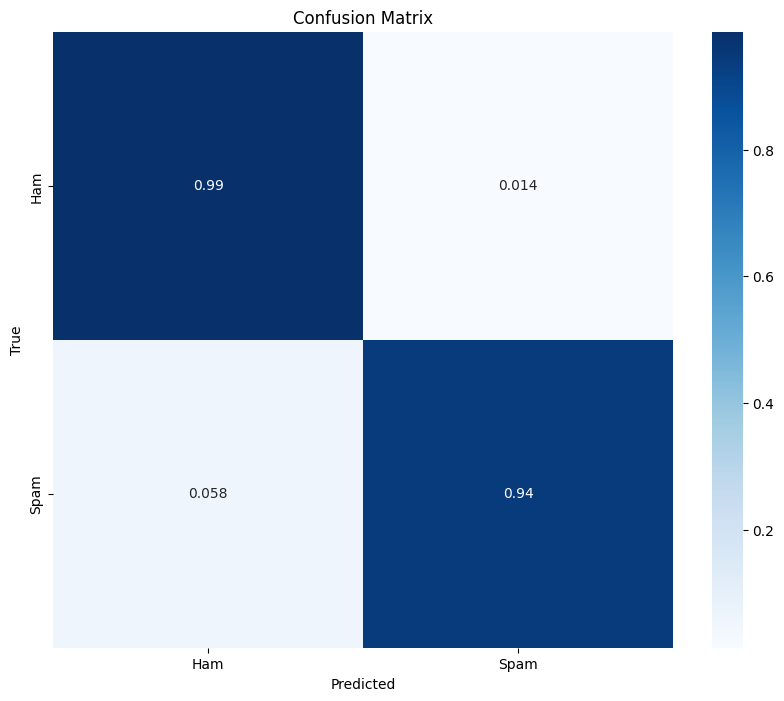

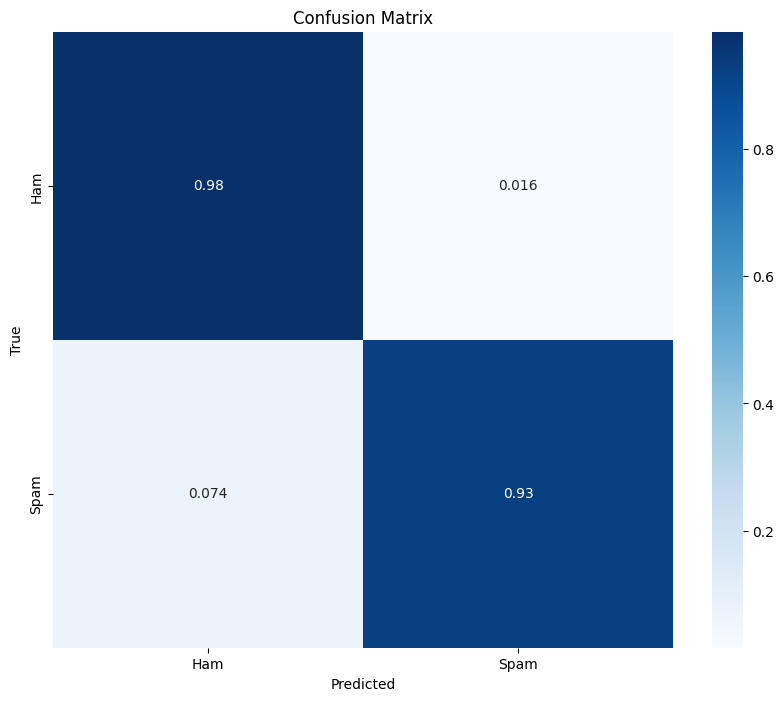

In [12]:
def predict_for_dataset(model, dataloader):
    predictions = np.array([])

    for batch in dataloader:
        text, labels = batch
        text, labels = text, labels
        
        predictions = np.append(predictions, torch.round(torch.sigmoid(model(text))).detach().numpy())

    return predictions

test_predictions = predict_for_dataset(model, test_loader)
val_predictions = predict_for_dataset(model, val_loader)

conf_matrix_test = confusion_matrix(labels_test, test_predictions, normalize='true')
conf_matrix_val = confusion_matrix(labels_val, val_predictions, normalize='true')

class_labels = ['Ham', 'Spam']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_val, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

Good results overall (~98% general accuracy). However, class-wise accuracy is unbalanced, we get slightly more false negatives (in percentage terms) for spam mails than for ham mails. The reason for this is probably the higher presence of ham mails in the dataset than spam mails. Let's try to fix this with a weighted loss.

In [13]:
N_ham_train = len(labels_train[labels_train == 0])
N_spam_train = len(labels_train[labels_train == 1])

print(f"Ham mails in training set: {N_ham_train}")
print(f"Spam mails in training set: {N_spam_train}")


pos_weight_value = N_ham_train / N_spam_train
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32)

Ham mails in training set: 2940
Spam mails in training set: 1196


In [14]:
model = TransformerModel(VOCAB_SIZE, EMBED_DIM, NUM_HEADS, NUM_LAYERS, HIDDEN_DIM, OUTPUT_DIM, DROPOUT, MAX_LEN)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor) # Better than BCELoss after a sigmoid

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

/home/jsarrato/BaseMLenv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [15]:
pos_weight_tensor

tensor([2.4582])

In [16]:
for epoch in tqdm.tqdm(range(N_EPOCHS)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    print(f"Epoch: {epoch+1}")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\tVal Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.2f}%")

test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

  3%|▎         | 1/30 [00:07<03:36,  7.45s/it]

Epoch: 1
	Train Loss: 0.888 | Train Acc: 58.29%
	Val Loss: 0.700 | Val Acc: 78.85%


  7%|▋         | 2/30 [00:14<03:27,  7.40s/it]

Epoch: 2
	Train Loss: 0.583 | Train Acc: 81.04%
	Val Loss: 0.508 | Val Acc: 86.49%


 10%|█         | 3/30 [00:22<03:19,  7.38s/it]

Epoch: 3
	Train Loss: 0.445 | Train Acc: 86.13%
	Val Loss: 0.453 | Val Acc: 90.45%


 13%|█▎        | 4/30 [00:29<03:11,  7.37s/it]

Epoch: 4
	Train Loss: 0.372 | Train Acc: 89.48%
	Val Loss: 0.373 | Val Acc: 91.67%


 17%|█▋        | 5/30 [00:36<03:04,  7.37s/it]

Epoch: 5
	Train Loss: 0.330 | Train Acc: 89.88%
	Val Loss: 0.409 | Val Acc: 91.15%


 20%|██        | 6/30 [00:44<02:56,  7.34s/it]

Epoch: 6
	Train Loss: 0.299 | Train Acc: 90.88%
	Val Loss: 0.353 | Val Acc: 92.88%


 23%|██▎       | 7/30 [00:51<02:49,  7.35s/it]

Epoch: 7
	Train Loss: 0.249 | Train Acc: 92.44%
	Val Loss: 0.335 | Val Acc: 93.40%


 27%|██▋       | 8/30 [00:58<02:41,  7.36s/it]

Epoch: 8
	Train Loss: 0.236 | Train Acc: 93.32%
	Val Loss: 0.497 | Val Acc: 92.01%


 30%|███       | 9/30 [01:06<02:34,  7.35s/it]

Epoch: 9
	Train Loss: 0.211 | Train Acc: 93.90%
	Val Loss: 0.399 | Val Acc: 93.58%


 33%|███▎      | 10/30 [01:13<02:27,  7.37s/it]

Epoch: 10
	Train Loss: 0.188 | Train Acc: 94.60%
	Val Loss: 0.290 | Val Acc: 95.66%


 37%|███▋      | 11/30 [01:21<02:20,  7.38s/it]

Epoch: 11
	Train Loss: 0.177 | Train Acc: 94.99%
	Val Loss: 0.288 | Val Acc: 95.49%


 40%|████      | 12/30 [01:28<02:13,  7.40s/it]

Epoch: 12
	Train Loss: 0.157 | Train Acc: 95.57%
	Val Loss: 0.271 | Val Acc: 95.66%


 43%|████▎     | 13/30 [01:35<02:05,  7.38s/it]

Epoch: 13
	Train Loss: 0.142 | Train Acc: 96.10%
	Val Loss: 0.243 | Val Acc: 96.01%


 47%|████▋     | 14/30 [01:43<01:58,  7.40s/it]

Epoch: 14
	Train Loss: 0.122 | Train Acc: 96.54%
	Val Loss: 0.336 | Val Acc: 95.83%


 50%|█████     | 15/30 [01:50<01:51,  7.40s/it]

Epoch: 15
	Train Loss: 0.129 | Train Acc: 96.57%
	Val Loss: 0.281 | Val Acc: 96.01%


 53%|█████▎    | 16/30 [01:58<01:43,  7.42s/it]

Epoch: 16
	Train Loss: 0.118 | Train Acc: 96.66%
	Val Loss: 0.263 | Val Acc: 95.49%


 57%|█████▋    | 17/30 [02:05<01:36,  7.43s/it]

Epoch: 17
	Train Loss: 0.126 | Train Acc: 96.62%
	Val Loss: 0.205 | Val Acc: 96.01%


 60%|██████    | 18/30 [02:13<01:29,  7.43s/it]

Epoch: 18
	Train Loss: 0.097 | Train Acc: 97.58%
	Val Loss: 0.210 | Val Acc: 96.53%


 63%|██████▎   | 19/30 [02:20<01:21,  7.44s/it]

Epoch: 19
	Train Loss: 0.101 | Train Acc: 97.35%
	Val Loss: 0.214 | Val Acc: 96.18%


 67%|██████▋   | 20/30 [02:27<01:14,  7.44s/it]

Epoch: 20
	Train Loss: 0.092 | Train Acc: 97.43%
	Val Loss: 0.297 | Val Acc: 96.01%


 70%|███████   | 21/30 [02:35<01:06,  7.42s/it]

Epoch: 21
	Train Loss: 0.081 | Train Acc: 97.52%
	Val Loss: 0.439 | Val Acc: 95.66%


 73%|███████▎  | 22/30 [02:42<00:59,  7.41s/it]

Epoch: 22
	Train Loss: 0.088 | Train Acc: 97.59%
	Val Loss: 0.222 | Val Acc: 96.35%


 77%|███████▋  | 23/30 [02:50<00:52,  7.44s/it]

Epoch: 23
	Train Loss: 0.077 | Train Acc: 97.88%
	Val Loss: 0.316 | Val Acc: 95.66%


 80%|████████  | 24/30 [02:57<00:44,  7.45s/it]

Epoch: 24
	Train Loss: 0.069 | Train Acc: 98.21%
	Val Loss: 0.187 | Val Acc: 97.22%


 83%|████████▎ | 25/30 [03:05<00:37,  7.45s/it]

Epoch: 25
	Train Loss: 0.073 | Train Acc: 98.10%
	Val Loss: 0.378 | Val Acc: 95.83%


 87%|████████▋ | 26/30 [03:12<00:29,  7.44s/it]

Epoch: 26
	Train Loss: 0.062 | Train Acc: 98.40%
	Val Loss: 0.285 | Val Acc: 96.53%


 90%|█████████ | 27/30 [03:19<00:22,  7.42s/it]

Epoch: 27
	Train Loss: 0.066 | Train Acc: 98.15%
	Val Loss: 0.330 | Val Acc: 96.01%


 93%|█████████▎| 28/30 [03:27<00:14,  7.43s/it]

Epoch: 28
	Train Loss: 0.055 | Train Acc: 98.48%
	Val Loss: 0.242 | Val Acc: 96.70%


 97%|█████████▋| 29/30 [03:34<00:07,  7.43s/it]

Epoch: 29
	Train Loss: 0.052 | Train Acc: 98.58%
	Val Loss: 0.302 | Val Acc: 96.88%


100%|██████████| 30/30 [03:42<00:00,  7.41s/it]

Epoch: 30
	Train Loss: 0.051 | Train Acc: 98.49%
	Val Loss: 0.336 | Val Acc: 96.53%
Test Loss: 0.088 | Test Acc: 98.61%


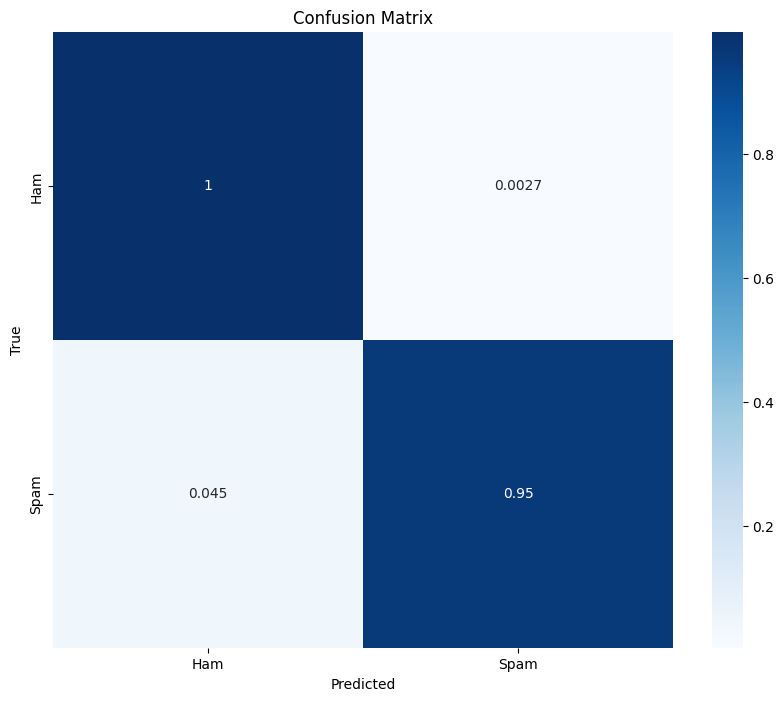

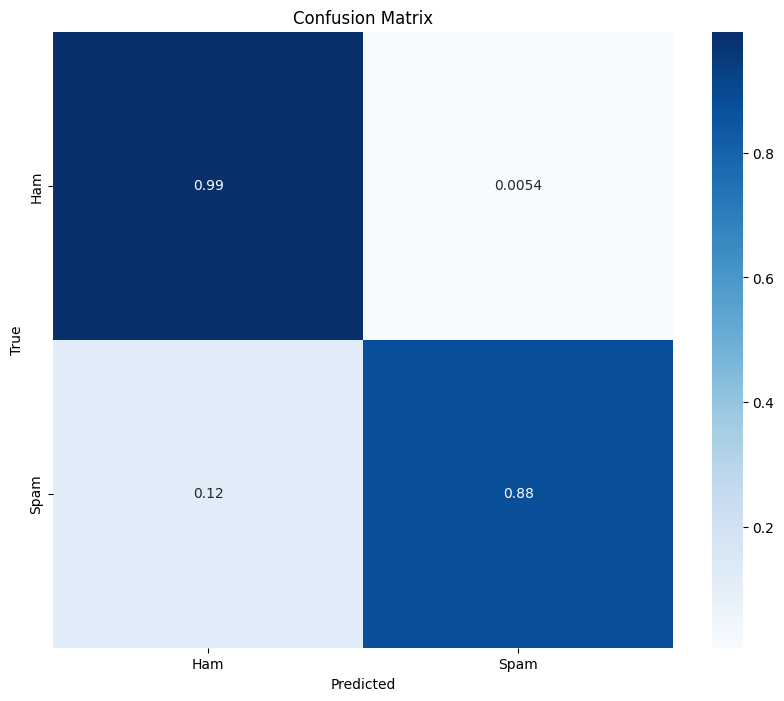

In [17]:
def predict_for_dataset(model, dataloader):
    predictions = np.array([])

    for batch in dataloader:
        text, labels = batch
        text, labels = text, labels
        
        predictions = np.append(predictions, torch.round(torch.sigmoid(model(text))).detach().numpy())

    return predictions

test_predictions = predict_for_dataset(model, test_loader)
val_predictions = predict_for_dataset(model, val_loader)

conf_matrix_test = confusion_matrix(labels_test, test_predictions, normalize='true')
conf_matrix_val = confusion_matrix(labels_val, val_predictions, normalize='true')

class_labels = ['Ham', 'Spam']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_val, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()